Need to explore:
1. Number of items
2. Number of users
3. Number of interactions
4. Distributions of likes, played ratio, etc
5. Size of the dataset.
6. Explore the album-item mapping, artist-item mapping, and etc.
7. Maybe draw some graph of these interactions

In [88]:
from typing import Literal
from datasets import Dataset, DatasetDict, load_dataset
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from collections import defaultdict
import numpy as np
from networkx.algorithms import bipartite
import random

## Dataset Class

In [59]:
class YambdaDataset:
  INTERACTIONS = frozenset(["likes", "listens", "multi_event", "dislikes", "unlikes", "undislikes"])

  def __init__(
      self,
      dataset_type: Literal["flat", "sequential"] = "flat",
      dataset_size: Literal["50m", "500m", "5b"] = "50m"
  ):
    assert dataset_type in {"flat", "sequential"}
    assert dataset_size in {"50m", "500m", "5b"}
    self.dataset_type = dataset_type
    self.dataset_size = dataset_size

  def interaction(self, event_type: Literal["likes", "listens", "multi_event", "dislikes", "unlikes", "undislikes"]) -> Dataset:
    assert event_type in self.INTERACTIONS
    return self._download(f"{self.dataset_type}/{self.dataset_size}", event_type)

  def audio_embeddings(self) -> Dataset:
    return self._download("", "embeddings")

  def album_item_mapping(self) -> Dataset:
    return self._download("", "album_item_mapping")

  def artist_item_mapping(self) -> Dataset:
    return self._download("", "artist_item_mapping")

  @staticmethod
  def _download(data_dir: str, file: str) -> Dataset:
    data = load_dataset("yandex/yambda", data_dir=data_dir, data_files=f"{file}.parquet")
    assert isinstance(data, DatasetDict)
    return data["train"]



In [60]:
dataset = YambdaDataset("flat", "50m")
listens = dataset.interaction("listens")
likes = dataset.interaction("likes")
dislikes = dataset.interaction("dislikes")

In [61]:
listens_df = listens.to_pandas()
likes_df = likes.to_pandas()
dislikes_df = dislikes.to_pandas()

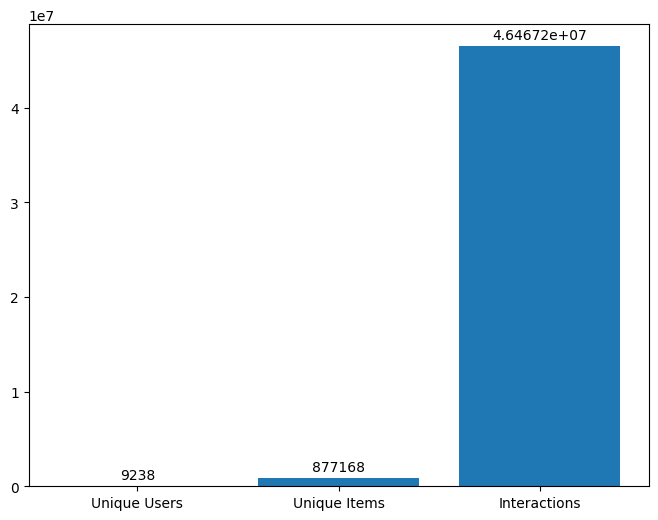

In [62]:
number_of_unique_uid = listens_df["uid"].nunique()
number_of_unique_item_id = listens_df["item_id"].nunique()
number_of_interactions = listens_df.shape[0]

categories = ["Unique Users", "Unique Items", "Interactions"]
values = [number_of_unique_uid, number_of_unique_item_id, number_of_interactions]

fig, ax = plt.subplots(figsize=(8, 6))
bars = ax.bar(categories, values)
ax.bar_label(bars, padding=3)
plt.show()

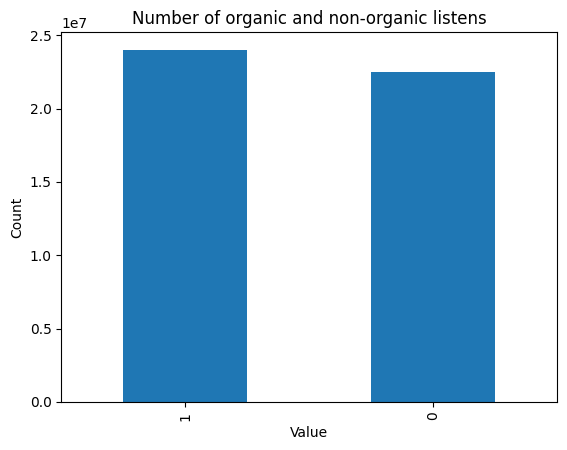

In [63]:
listens_df["is_organic"].value_counts().plot(kind="bar", title="Number of organic and non-organic listens")
plt.xlabel("Value")
plt.ylabel("Count")
plt.show()


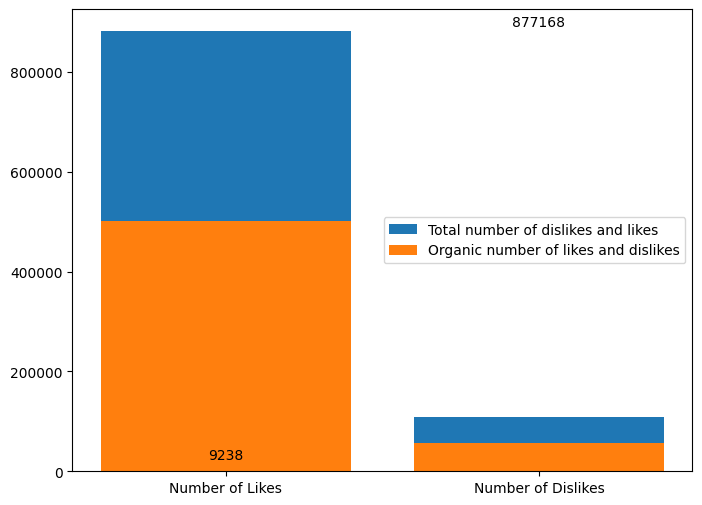

In [64]:
categories = ["Number of Likes", "Number of Dislikes"]
values = [likes_df.shape[0], dislikes_df.shape[0]]
organics = [likes_df["is_organic"].sum(), dislikes_df["is_organic"].sum()]

fig, ax = plt.subplots(figsize=(8, 6))
bars1 = ax.bar(categories, values, label = "Total number of dislikes and likes")
bars2 = ax.bar(categories, organics, label ="Organic number of likes and dislikes")
ax.bar_label(bars, padding=3)
ax.legend()
plt.show()


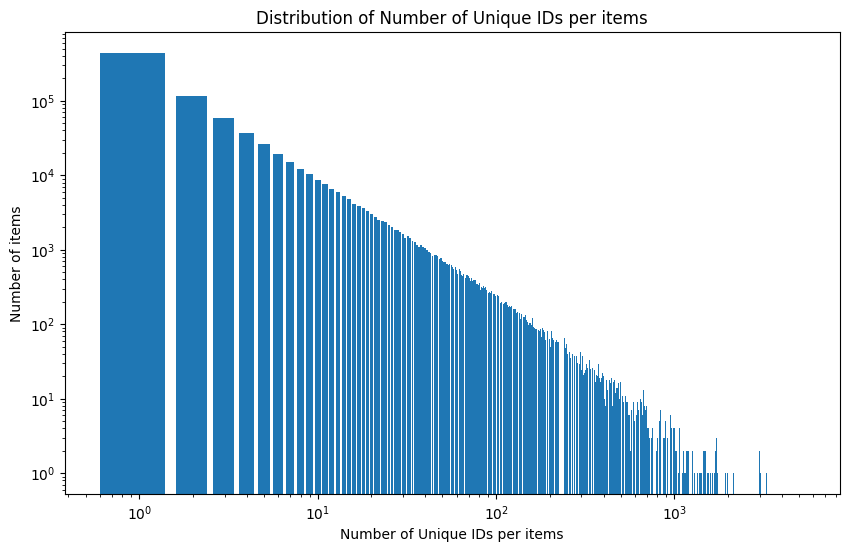

In [65]:
per_item_distribution = listens_df.groupby("item_id").agg({"uid": "nunique"}).reset_index()
hist_data = per_item_distribution.groupby("uid").size().reset_index(name="items_count")

plt.figure(figsize=(10, 6))
plt.bar(hist_data["uid"], hist_data["items_count"])
plt.xlabel("Number of Unique IDs per items")
plt.ylabel("Number of items")
plt.title("Distribution of Number of Unique IDs per items")
plt.xscale('log')
plt.yscale('log')
plt.show()


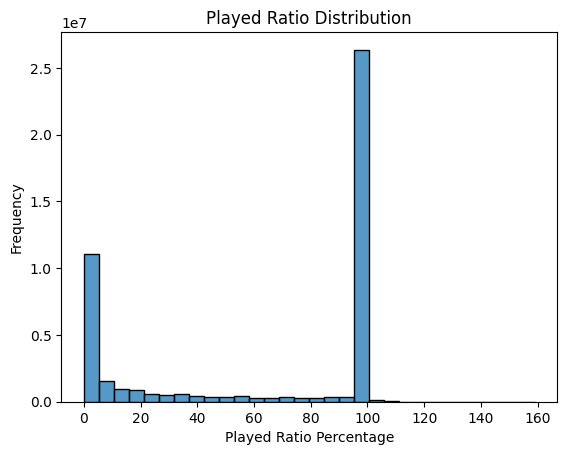

In [66]:
sns.histplot(listens_df["played_ratio_pct"], bins=30)

plt.xlabel("Played Ratio Percentage")
plt.ylabel("Frequency")
plt.title("Played Ratio Distribution")
plt.show()

In [77]:
sampled_listens_df = listens_df.sample(frac=0.001)

In [79]:
B = nx.Graph()

users = sampled_listens_df["uid"].unique()
items = sampled_listens_df["item_id"].unique()
B.add_nodes_from(users, bipartite="user")
B.add_nodes_from(items, bipartite="item")


In [80]:
agg = sampled_listens_df.groupby(["uid", "item_id"]).agg(
    n_listens=("uid", "count"),
    mean_play=("played_ratio_pct", "mean"),
    is_organic=("is_organic", "max"),
    first_ts=("timestamp", "min"),
    last_ts=("timestamp", "max"),
).reset_index()

In [81]:
B.add_edges_from(
    (row.uid, row.item_id, dict(
      n_listens=int(row.n_listens),
      mean_play=float(row.mean_play),
      is_organic=int(row.is_organic),
      first_ts=row.first_ts,
      last_ts=row.last_ts
    ))
    for _, row in agg.iterrows()
)

In [82]:
liked = set(zip(likes_df["uid"], likes_df["item_id"]))
disliked = set(zip(dislikes_df["uid"], dislikes_df["item_id"]))
for (u, i) in set(B.edges()):
  B[u][i]["liked"] = int((u, i) in liked)
  B[u][i]["disliked"] = int((u, i) in disliked)


In [84]:
def sample_user_item_subgraph(B, n_users):
  U = [n for n, d in B.nodes(data=True) if d["bipartite"] == "user"]
  U = set(random.sample(U, min(len(U), n_users)))
  I = set().union(*[set(B.neighbors(u)) for u in U])
  return B.subgraph(U | I).copy()


In [107]:
S = sample_user_item_subgraph(B, 5)

In [108]:
U = [n for n, d in S.nodes(data=True) if d['bipartite'] == "user"]
I = [n for n, d in S.nodes(data=True) if d['bipartite'] == "item"]

In [109]:
pos = nx.bipartite_layout(S, nodes=U)

In [110]:
node_color = ["tab:orange" if n in U else "tab:blue" for n in S.nodes()]
node_size = [max(30, 10*np.sqrt(S.degree(n))) for n in S.nodes()]

In [111]:
def edge_width(u, v):
  w = S[u][v].get("n_listens", 1)
  return 1 + np.log1p(w)

In [112]:
edge_w = [edge_width(u, v) for u, v in S.edges()]
edge_c = ["tab:green" if S[u][v]["liked"]==1 else "tab:red" for u, v in S.edges()]

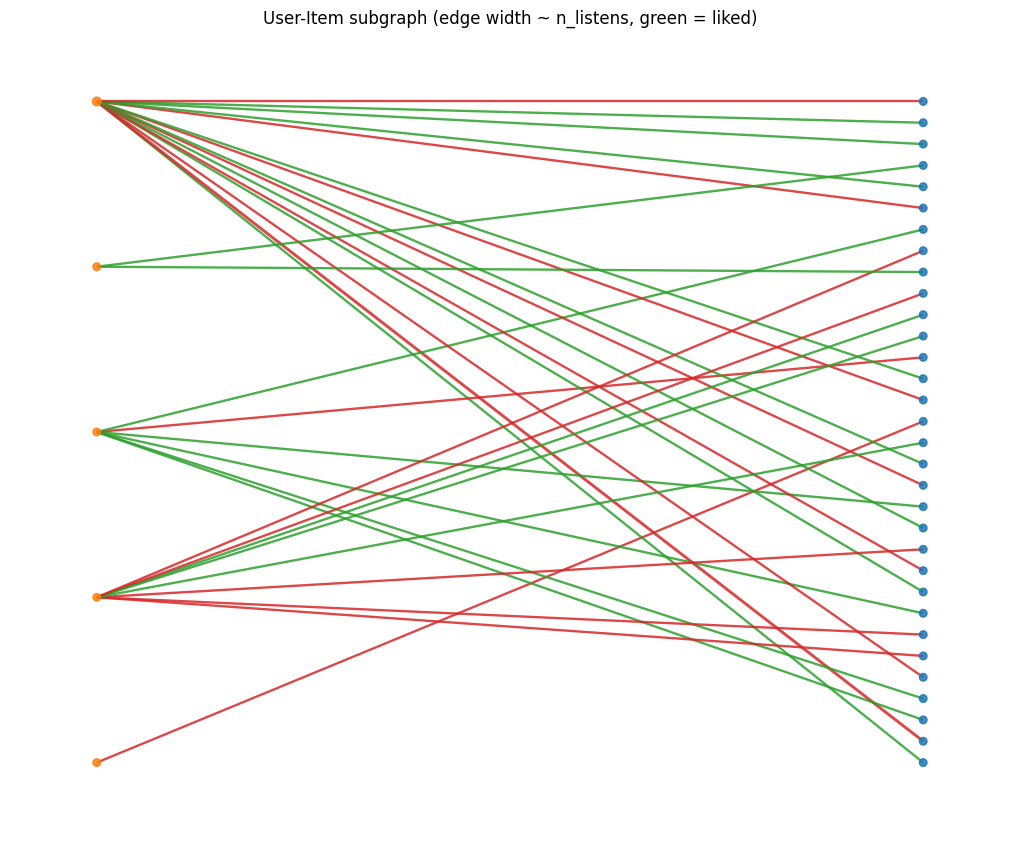

In [113]:
plt.figure(figsize=(10, 8))
nx.draw(S, pos, node_color=node_color, node_size=node_size, width=edge_w,
        edge_color=edge_c, with_labels=False, alpha=0.85)
plt.title("User-Item subgraph (edge width ~ n_listens, green = liked)")
plt.show()